In [1]:
import tensorflow as tf
from tensorflow import keras


if tf.test.gpu_device_name()=='':
    print('You do not have GPU access.')
    !nvidia-smi

else:
  print('You have GPU access')
  !nvidia-smi


# print the tensorflow version
print('TensorFlow {}; Keras {}'.format(tf.__version__, keras.__version__))
tf.test.gpu_device_name()


C:\Users\Jens\miniconda3\envs\tensorflow\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


You have GPU access
Wed Nov  2 13:43:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.72       Driver Version: 512.72       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   55C    P0    15W /  N/A |    168MiB /  4096MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                    

'/device:GPU:0'

In [2]:
from tensorflow.keras import layers
import os
import tifffile as tiff
import numpy as np
from matplotlib import pyplot as plt
from keras.models import load_model
from preprocessing import get_model_memory_usage, unpatch_stack

#load pretrained models
model_single_name = "bactunet_V4_single_frame"
model_3frame_name = "bactunet_V4_3frame"

model_single = load_model("models/"+model_single_name+".hdf5", compile=False)
model_3frame = load_model("models/"+model_3frame_name+".hdf5", compile=False)


In [3]:
#models are identical except for the input shape (1, 288, 288) vs (3, 288, 288)
for l1, l2 in zip(model_single.weights, model_3frame.weights):
    print(l1.name, l1.shape, l2.name, l2.shape)

conv2d/kernel:0 (3, 3, 1, 64) conv2d/kernel:0 (3, 3, 3, 64)
conv2d/bias:0 (64,) conv2d/bias:0 (64,)
batch_normalization/gamma:0 (288,) batch_normalization/gamma:0 (288,)
batch_normalization/beta:0 (288,) batch_normalization/beta:0 (288,)
batch_normalization/moving_mean:0 (288,) batch_normalization/moving_mean:0 (288,)
batch_normalization/moving_variance:0 (288,) batch_normalization/moving_variance:0 (288,)
conv2d_1/kernel:0 (3, 3, 64, 64) conv2d_1/kernel:0 (3, 3, 64, 64)
conv2d_1/bias:0 (64,) conv2d_1/bias:0 (64,)
batch_normalization_1/gamma:0 (288,) batch_normalization_1/gamma:0 (288,)
batch_normalization_1/beta:0 (288,) batch_normalization_1/beta:0 (288,)
batch_normalization_1/moving_mean:0 (288,) batch_normalization_1/moving_mean:0 (288,)
batch_normalization_1/moving_variance:0 (288,) batch_normalization_1/moving_variance:0 (288,)
conv2d_2/kernel:0 (3, 3, 64, 128) conv2d_2/kernel:0 (3, 3, 64, 128)
conv2d_2/bias:0 (128,) conv2d_2/bias:0 (128,)
batch_normalization_2/gamma:0 (144,) bat

In [4]:
from preprocessing import patch_image, patch_stack, normalizePercentile, normalizeMinMax
from patchify import patchify

source_path = r"Bactnet/Training data/stacks/"
SIZE = 288

def prepare_data(source_path, PATCH_SIZE, validation=True):
    pred_dict = {}
    if validation:
        prefix = "validation"
    else:
        prefix = "training"
    stacks = os.listdir(os.path.join(source_path, prefix+"_source"))
    image_dataset = None
    mask_dataset = None
    for stack in stacks:
        if (stack.split(".")[-1]=="tif"):
            pred_dict[stack]={}
            img = tiff.imread(os.path.join(source_path, prefix+"_source",stack))
            pred_dict[stack]["image"]=img
            mask = tiff.imread(os.path.join(source_path, prefix+"_target", stack))
            pred_dict[stack]["y_true"]=mask
            print(stack, img.shape, mask.shape)
            
            img_patch = patch_stack(img, PATCH_SIZE)
            if len(mask.shape)==2:
                mask_patch = patch_image(mask, PATCH_SIZE)
            else:    
                mask_patch = patch_stack(mask, SIZE=PATCH_SIZE, DEPTH=1)
            
            print(stack, img_patch.shape, mask_patch.shape)
            mask_patch = normalizeMinMax(mask_patch)
            img_patch = normalizePercentile(img_patch, 0.1, 99.9, clip=True)
            pred_dict[stack]["image_patch"] = img_patch
            pred_dict[stack]["mask_patch"] = mask_patch


            #print(image_dataset.shape, mask_dataset.shape)

    return pred_dict

#pred_dict[file]=[image_stack, mask, patch, y_true, y_pred]
image_dict = prepare_data(source_path, SIZE, validation=True)
image_dict.update(prepare_data(source_path, SIZE, validation=False))
print(image_dict.keys())



BT0403_229.tif (13, 2304, 2304) (11, 2304, 2304)
BT0403_229.tif (704, 3, 288, 288) (704, 1, 288, 288)
BT0407_110.tif (7, 2304, 2304) (5, 2304, 2304)
BT0407_110.tif (320, 3, 288, 288) (320, 1, 288, 288)
BT0398_210.tif (13, 2304, 2304) (11, 2304, 2304)
BT0398_210.tif (704, 3, 288, 288) (704, 1, 288, 288)
BT402_169.tif (5, 2304, 2304) (3, 2304, 2304)
BT402_169.tif (192, 3, 288, 288) (192, 1, 288, 288)
BT403_002.tif (13, 2304, 2304) (11, 2304, 2304)
BT403_002.tif (704, 3, 288, 288) (704, 1, 288, 288)
BT404_199.tif (5, 2304, 2304) (3, 2304, 2304)
BT404_199.tif (192, 3, 288, 288) (192, 1, 288, 288)
dict_keys(['BT0403_229.tif', 'BT0407_110.tif', 'BT0398_210.tif', 'BT402_169.tif', 'BT403_002.tif', 'BT404_199.tif'])


In [5]:
keras.backend.clear_session()
stride = 2

# #IOU
for stack in image_dict.keys():
    y_pred1 = None
    y_pred2 = None
    img_stack = image_dict[stack]
    for i in range(0, len(img_stack["image_patch"]), stride):
        pred_si = model_single.predict(np.expand_dims(img_stack["image_patch"][i:i+stride,1,:,:], axis=1))
        pred_3f = model_3frame.predict(img_stack["image_patch"][i:i+stride])
        if y_pred1 is not None:
            y_pred1 = np.concatenate((y_pred1, pred_si))
            y_pred2 = np.concatenate((y_pred2, pred_3f))

        if y_pred1 is None:
            y_pred1 = pred_si
            y_pred2 = pred_3f
    
    image_dict[stack]["y_pred_single"] = unpatch_stack(y_pred1, 8, 8, 1)
    image_dict[stack]["y_pred_3frame"] = unpatch_stack(y_pred2, 8, 8, 1)
    print(stack, image_dict[stack]["y_pred_single"].shape, image_dict[stack]["y_pred_3frame"].shape)
    

BT0403_229.tif (11, 1, 2304, 2304) (11, 1, 2304, 2304)
BT0407_110.tif (5, 1, 2304, 2304) (5, 1, 2304, 2304)
BT0398_210.tif (11, 1, 2304, 2304) (11, 1, 2304, 2304)
BT402_169.tif (3, 1, 2304, 2304) (3, 1, 2304, 2304)
BT403_002.tif (11, 1, 2304, 2304) (11, 1, 2304, 2304)
BT404_199.tif (3, 1, 2304, 2304) (3, 1, 2304, 2304)


In [20]:
threshold = 0.5

for stack in image_dict.keys():
    pred_si = (image_dict[stack]["y_pred_single"]>threshold)*255
    pred_3f = (image_dict[stack]["y_pred_3frame"]>threshold)*255
    saveme = np.concatenate((pred_si, pred_3f, np.expand_dims(image_dict[stack]["y_true"],axis=1)), axis=1)
    saveme = saveme.astype('uint8')
    prefix="V4_compare"
    dic = unpatch_stack(image_dict[stack]["image_patch"], 8, 8, 3)
    dic = dic[:,1,:,:] * 255
    dic = np.expand_dims(dic, axis=1).astype('uint8')
    print(dic.shape, image_dict[stack]["image_patch"].max())
    saveme = np.concatenate((dic, saveme), axis=1)
    tiff.imwrite(os.path.join(r"C:\Users\Jens\Documents\Code\BactUnet\Bactnet\Training data\stacks\predict", prefix+stack), saveme, imagej=True,
                      metadata={'unit': 'um', 'finterval': 15,
                                'axes': 'TCYX'})

(11, 1, 2304, 2304) 1.0
(5, 1, 2304, 2304) 1.0
(11, 1, 2304, 2304) 1.0
(3, 1, 2304, 2304) 1.0
(11, 1, 2304, 2304) 1.0
(3, 1, 2304, 2304) 1.0


In [6]:
#Quick look at the training
import pandas as pd
import seaborn as sns

log_si = pd.read_csv("models/"+model_single_name+".csv")
log_3m = pd.read_csv("models/"+model_3frame_name+".csv")

log_si["Model"] = "single"
log_3m["Model"] = "3frame"

train_logs = pd.concat([log_si, log_3m], ignore_index=True)

train_logs.head()



,epoch,dice_coef,iou_seg,loss,val_dice_coef,val_iou_seg,val_loss,Model
0,0,0.405609,0.734618,1.388661,0.482242,0.674140,1.311090,single
1,1,0.530784,0.632071,1.169838,0.527189,0.634532,1.232484,single
2,2,0.562878,0.601784,1.111608,0.547631,0.614936,1.191722,single
3,3,0.572708,0.592058,1.088279,0.542584,0.619917,1.200951,single
4,4,0.585001,0.580063,1.067117,0.510874,0.649524,1.274522,single


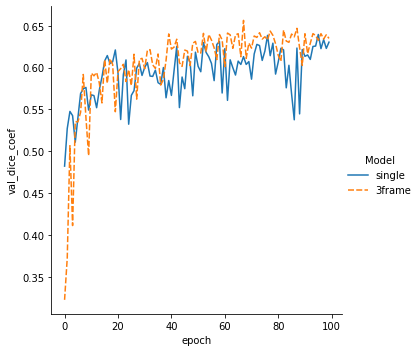

In [7]:
g1 = sns.relplot(data=train_logs, x='epoch', y='val_dice_coef', style='Model', hue='Model', kind='line')
#g1.set(ylim=(0,150))


In [7]:
def dice_score(mask1, mask2):
    intersect = np.sum(mask1*mask2)
    fsum = np.sum(mask1)
    ssum = np.sum(mask2)
    dice = (2 * intersect ) / (fsum + ssum)
    dice = np.mean(dice)
    dice = round(dice, 3) # for easy reading
    return dice    

def iou_score(mask1, mask2):
    intersection = np.logical_and(mask1, mask1)
    union = np.logical_or(mask1, mask2)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score
    

for stack in image_dict.keys():
    for frame in range(len(image_dict[stack]['y_pred_single'])):
        dice_comp = dice_score(image_dict[stack]['y_pred_single'][frame], image_dict[stack]['y_pred_3frame'][frame])
        iou_comp = iou_score(image_dict[stack]['y_pred_single'][frame], image_dict[stack]['y_pred_3frame'][frame])
        print(stack, frame, dice_comp, iou_comp)


BT0403_229.tif 0 0.768 0.9998950711114569
BT0403_229.tif 1 0.785 0.9999054312063832
BT0403_229.tif 2 0.795 0.9998653058095017
BT0403_229.tif 3 0.787 0.9999165445919388
BT0403_229.tif 4 0.796 0.9998888520070125
BT0403_229.tif 5 0.791 0.9998856495023493
BT0403_229.tif 6 0.765 0.9998977059186451
BT0403_229.tif 7 0.78 0.9998960108480278
BT0403_229.tif 8 0.771 0.9998762291836137
BT0403_229.tif 9 0.756 0.9999007182011419
BT0403_229.tif 10 0.752 0.9999095732195061
BT0407_110.tif 0 0.739 0.9999900158503086
BT0407_110.tif 1 0.61 0.9999917112750771
BT0407_110.tif 2 0.673 0.9999939718352842
BT0407_110.tif 3 0.734 0.9999826689872642
BT0407_110.tif 4 0.754 0.9999918996551891
BT0398_210.tif 0 0.829 0.9999299193111294
BT0398_210.tif 1 0.87 0.999926904055167
BT0398_210.tif 2 0.828 0.9999020393153905
BT0398_210.tif 3 0.865 0.9998960102407306
BT0398_210.tif 4 0.847 0.9999250213538431
BT0398_210.tif 5 0.857 0.9999171085815414
BT0398_210.tif 6 0.813 0.9998890366307226
BT0398_210.tif 7 0.843 0.999928787474

In [8]:
from skimage import measure

threshold = 0.5
stack = 'BT0407_110.tif'
i = 3

contours_true = measure.find_contours(image_dict[stack]['y_true'][i]>1)
contours_single = measure.find_contours(image_dict[stack]["y_pred_single"][i,0,:,:]>threshold)
contours_3frame = measure.find_contours(image_dict[stack]["y_pred_3frame"][i,0,:,:]>threshold)

print(len(contours_true), len(contours_single), len(contours_3frame))


37 44 55


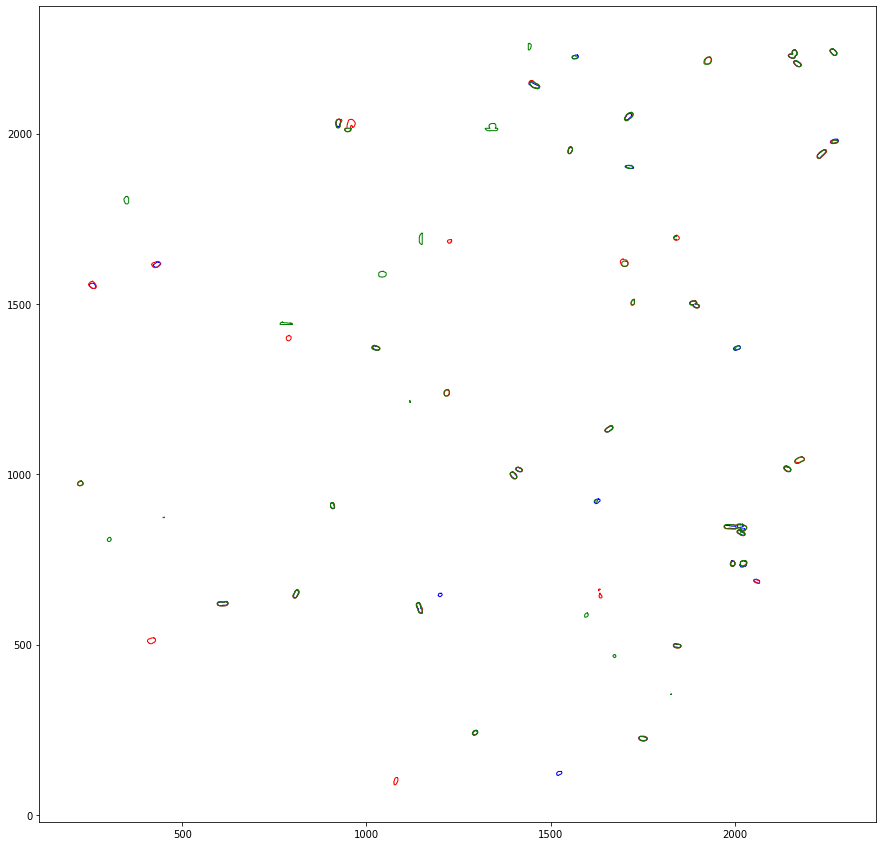

In [9]:
fig, ax = plt.subplots(figsize=(15, 15))
for contour in contours_true:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color='blue')
    
for contour in contours_single:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color='red')
    
for contour in contours_3frame:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color='green')

plt.show()


37 44 55 31 32 44


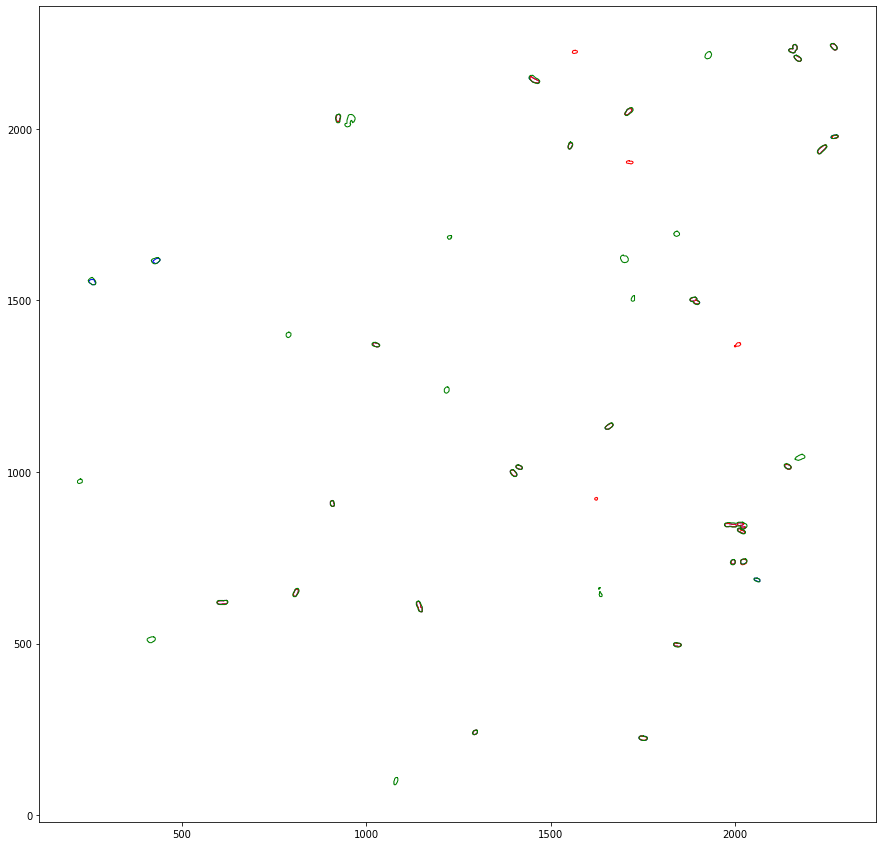

In [10]:
#ANDing two masks gives a quick count of whow well they agree

mask_true = image_dict[stack]['y_true'][i]>1
mask_single = image_dict[stack]["y_pred_single"][i,0,:,:]>threshold
mask_3frame = image_dict[stack]["y_pred_3frame"][i,0,:,:]>threshold

and_mask = np.logical_and(mask_true, mask_single)
and_mask2 = np.logical_and(mask_true, mask_3frame)
and_mask3 = np.logical_and(mask_single, mask_single)

contours_and = measure.find_contours(and_mask)
contours_and2 = measure.find_contours(and_mask2)
contours_and3 = measure.find_contours(and_mask3)

print(len(contours_true), len(contours_single), len(contours_3frame), len(contours_and), len(contours_and2), len(contours_and3))

fig, ax = plt.subplots(figsize=(15, 15))
for contour in contours_and:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color='blue')
for contour in contours_and2:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color='red')
for contour in contours_and3:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color='green')

plt.show()


In [11]:
count_compare = {}
threshold = 0.5 

def countmask(mask):
    #counts contours in binary 3D-array
    out=[]
    for frame in range(len(mask)):
        out.append(len(measure.find_contours(mask[frame])))
    return out
    
    
for stack in image_dict.keys():
    count_compare[stack] = {}
    mask_true = image_dict[stack]['y_true']>1
    mask_single = image_dict[stack]["y_pred_single"][:,0,:,:]>threshold
    mask_3frame = image_dict[stack]["y_pred_3frame"][:,0,:,:]>threshold
    
    and_single = np.logical_and(mask_true, mask_single)
    and_3frame = np.logical_and(mask_true, mask_3frame)
    single_and_3frame = np.logical_and(mask_single, mask_single)
     
    count_compare[stack]['frame'] = list(range(len(mask_true)))
    count_compare[stack]['true'] = countmask(mask_true)
    count_compare[stack]['single'] = countmask(mask_single)
    count_compare[stack]['3frame'] = countmask(mask_3frame)
    count_compare[stack]['true_and_single'] = countmask(and_single)
    count_compare[stack]['true_and_3frame'] = countmask(and_3frame)
    count_compare[stack]['3frame_and_single'] = countmask(single_and_3frame)




In [13]:
count_df = None
print(count_compare)
for stack in count_compare.keys():
    df = pd.DataFrame.from_dict(count_compare[stack])
    df['file'] = stack
    
    
    if count_df is None:
        count_df = df
    
    else:
        count_df = pd.concat([count_df, df], ignore_index=True)
count_df.head()

{'BT0403_229.tif': {'frame': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'true': [81, 76, 77, 78, 82, 82, 84, 81, 81, 79, 76], 'single': [96, 102, 102, 114, 119, 110, 114, 106, 110, 113, 97], '3frame': [111, 126, 135, 130, 123, 123, 115, 128, 101, 106, 118], 'true_and_single': [65, 63, 68, 70, 74, 67, 73, 69, 66, 66, 67], 'true_and_3frame': [72, 65, 64, 68, 74, 72, 71, 73, 62, 68, 67], '3frame_and_single': [96, 102, 102, 114, 119, 110, 114, 106, 110, 113, 97]}, 'BT0407_110.tif': {'frame': [0, 1, 2, 3, 4], 'true': [25, 28, 36, 37, 41], 'single': [55, 58, 40, 44, 46], '3frame': [70, 53, 48, 55, 62], 'true_and_single': [20, 19, 27, 31, 36], 'true_and_3frame': [22, 10, 28, 32, 39], '3frame_and_single': [55, 58, 40, 44, 46]}, 'BT0398_210.tif': {'frame': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'true': [163, 166, 163, 168, 165, 167, 155, 151, 148, 145, 137], 'single': [159, 161, 150, 153, 152, 158, 150, 143, 131, 147, 141], '3frame': [178, 184, 178, 183, 179, 178, 177, 191, 176, 168, 165], 'true_and_sing

,frame,true,single,3frame,true_and_single,true_and_3frame,3frame_and_single,file
0,0,81,96,111,65,72,96,BT0403_229.tif
1,1,76,102,126,63,65,102,BT0403_229.tif
2,2,77,102,135,68,64,102,BT0403_229.tif
3,3,78,114,130,70,68,114,BT0403_229.tif
4,4,82,119,123,74,74,119,BT0403_229.tif


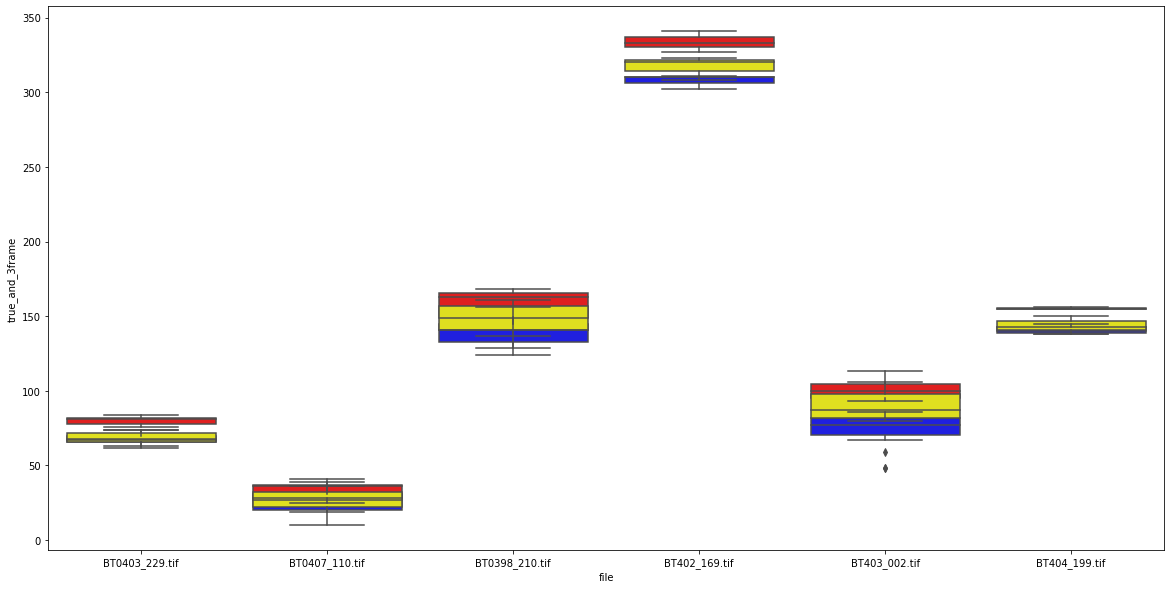

In [14]:
plt.figure(figsize=(20,10))
g1 = sns.boxplot(data=count_df, x='file', y='true', color='red')
g1 = sns.boxplot(data=count_df, x='file', y='true_and_single', color='blue')
g1 = sns.boxplot(data=count_df, x='file', y='true_and_3frame', color='yellow')

In [14]:
count_df['TP_fraction_single'] = count_df['true_and_single']/count_df['true']
count_df['TP_fraction_3frame'] = count_df['true_and_3frame']/count_df['true']
count_df['FP_fraction_single'] = (count_df['single']-count_df['true_and_single'])/count_df['single']
count_df['FP_fraction_3frame'] = (count_df['3frame']-count_df['true_and_3frame'])/count_df['3frame']
count_df.head()


,frame,true,single,3frame,true_and_single,true_and_3frame,3frame_and_single,file,TP_fraction_single,TP_fraction_3frame,FP_fraction_single,FP_fraction_3frame
0,0,81,96,111,65,72,96,BT0403_229.tif,0.802469,0.888889,0.322917,0.351351
1,1,76,102,126,63,65,102,BT0403_229.tif,0.828947,0.855263,0.382353,0.484127
2,2,77,102,135,68,64,102,BT0403_229.tif,0.883117,0.831169,0.333333,0.525926
3,3,78,114,130,70,68,114,BT0403_229.tif,0.897436,0.871795,0.385965,0.476923
4,4,82,119,123,74,74,119,BT0403_229.tif,0.902439,0.902439,0.378151,0.398374


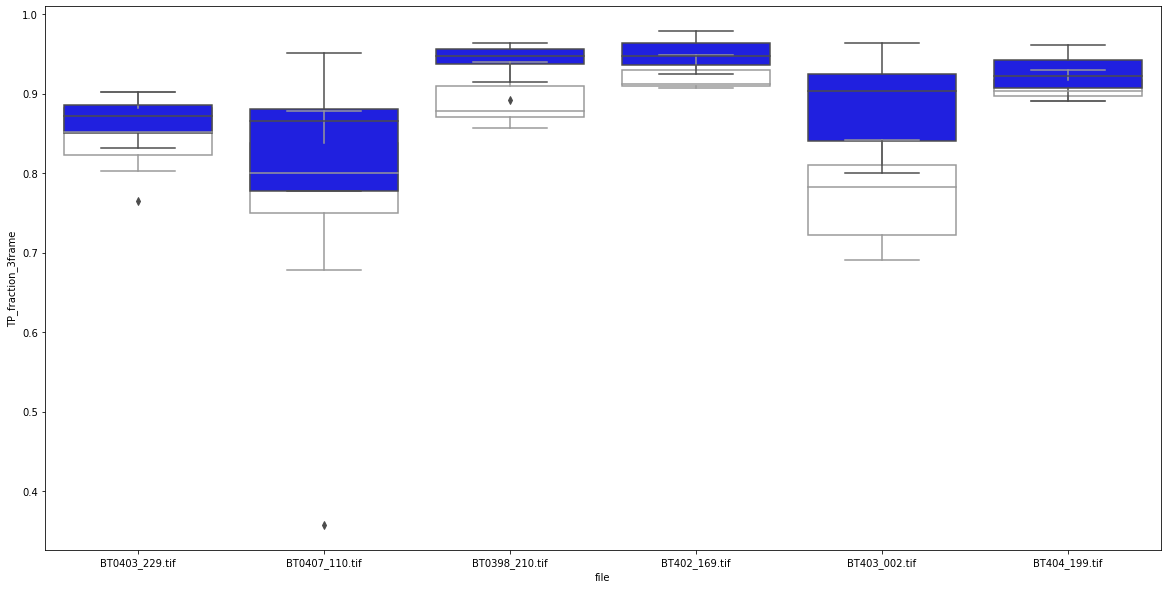

In [16]:
plt.figure(figsize=(20,10))
g1 = sns.boxplot(data=count_df, x='file', y='TP_fraction_single', color='white')
g1 = sns.boxplot(data=count_df, x='file', y='TP_fraction_3frame', color='blue')





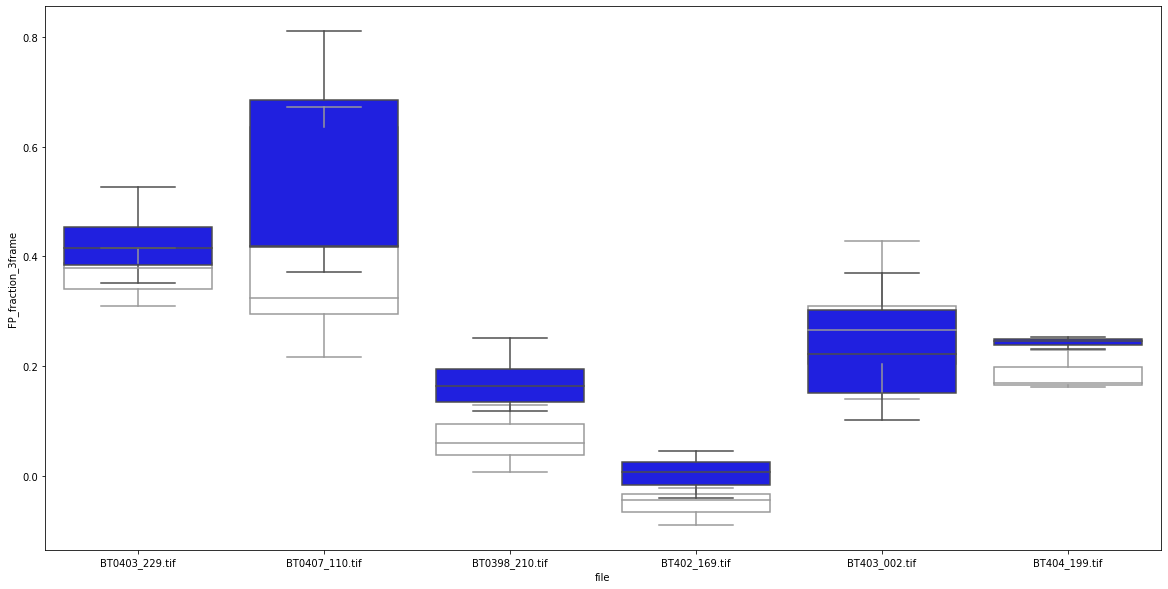

In [17]:
plt.figure(figsize=(20,10))
g2 = sns.boxplot(data=count_df, x='file', y='FP_fraction_single', color='white')
g2 = sns.boxplot(data=count_df, x='file', y='FP_fraction_3frame', color='blue')

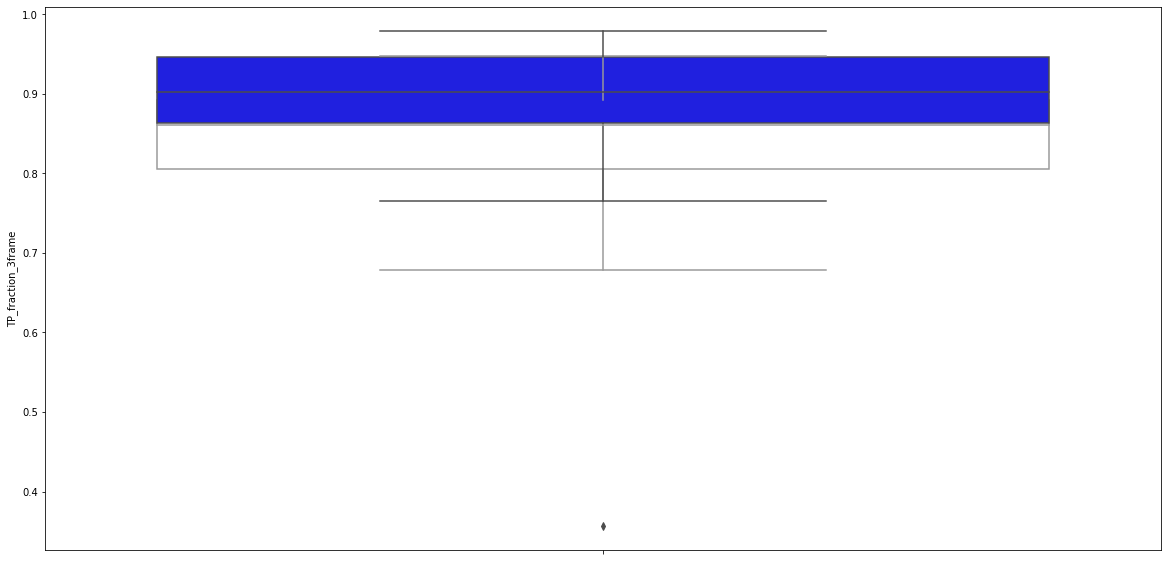

In [18]:
plt.figure(figsize=(20,10))
g1 = sns.boxplot(data=count_df, y='TP_fraction_single', color='white')
g1 = sns.boxplot(data=count_df, y='TP_fraction_3frame', color='blue')


Let's reformat the dataframe for easier plottting

In [15]:
count_df.head()

,frame,true,single,3frame,true_and_single,true_and_3frame,3frame_and_single,file,TP_fraction_single,TP_fraction_3frame,FP_fraction_single,FP_fraction_3frame
0,0,81,96,111,65,72,96,BT0403_229.tif,0.802469,0.888889,0.322917,0.351351
1,1,76,102,126,63,65,102,BT0403_229.tif,0.828947,0.855263,0.382353,0.484127
2,2,77,102,135,68,64,102,BT0403_229.tif,0.883117,0.831169,0.333333,0.525926
3,3,78,114,130,70,68,114,BT0403_229.tif,0.897436,0.871795,0.385965,0.476923
4,4,82,119,123,74,74,119,BT0403_229.tif,0.902439,0.902439,0.378151,0.398374


In [16]:
single = count_df.filter(items=['file', 'frame'])
single['model'] = 'single_frame'
single['TP'] = count_df['true_and_single']
single['FN'] = count_df['true']-count_df['true_and_single']
single['FP'] = count_df['single']-count_df['true_and_single']

multi = count_df.filter(items=['file', 'frame'])
multi['model'] = '3_frame'
multi['TP'] = count_df['true_and_3frame']
multi['FN'] = count_df['true']-count_df['true_and_3frame']
multi['FP'] = count_df['3frame']-count_df['true_and_3frame']

tp_df = pd.concat([single, multi], ignore_index=True)

tp_df['precision'] = tp_df['TP']/(tp_df['TP']+tp_df['FP'])
tp_df['recall'] = tp_df['TP']/(tp_df['TP']+tp_df['FN'])
tp_df['average_precision'] = tp_df['TP']/(tp_df['TP']+tp_df['FP']+tp_df['FN'])

tp_df.head()
tp_df.to_csv('single_vs_3frame_count.csv') 

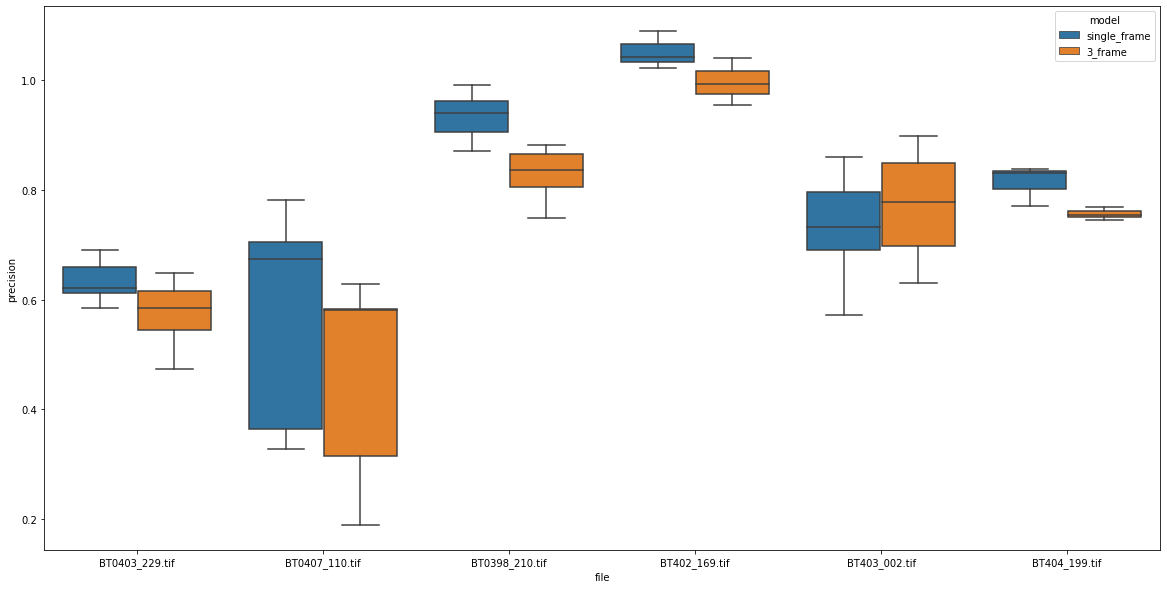

In [17]:
plt.figure(figsize=(20,10))
g3 = sns.boxplot(data=tp_df, x='file', y='precision', hue='model')

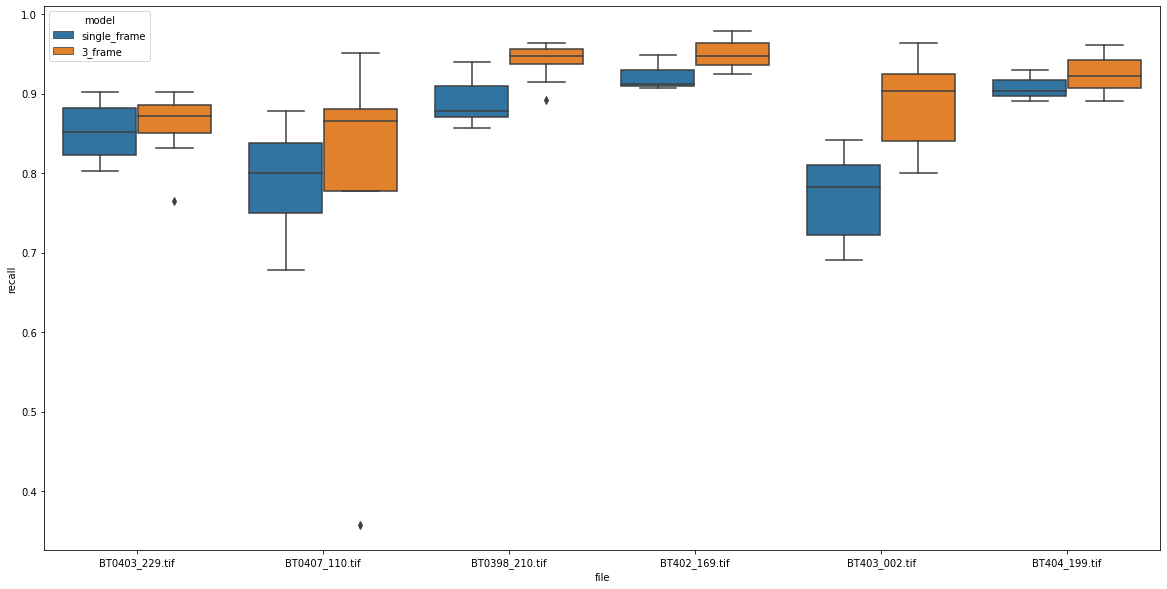

In [18]:
plt.figure(figsize=(20,10))
g3 = sns.boxplot(data=tp_df, x='file', y='recall', hue='model')

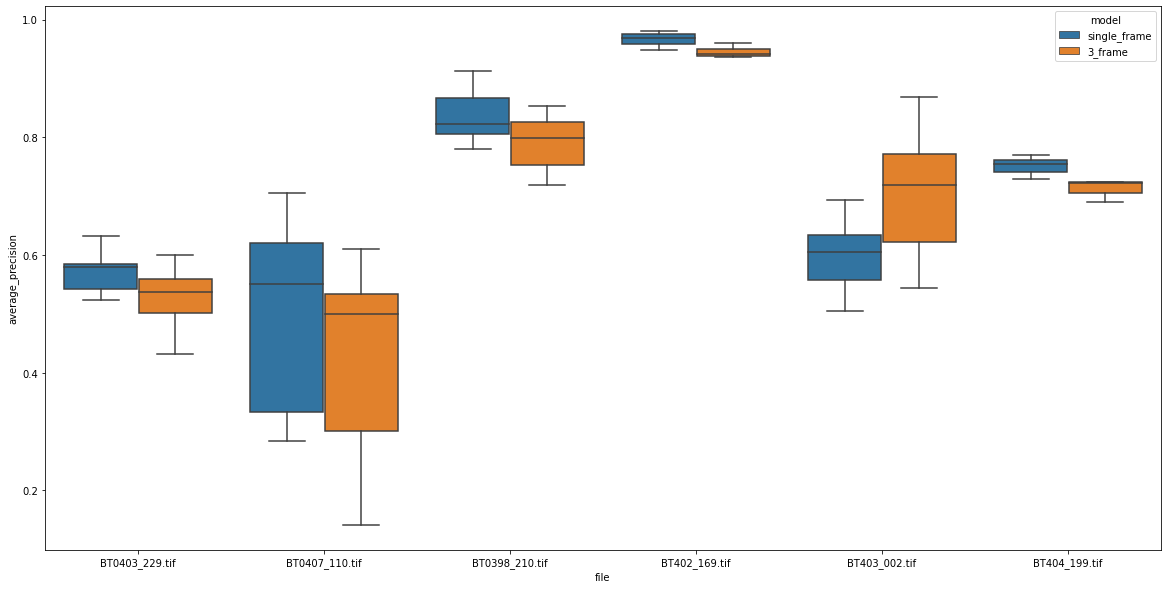

In [19]:
plt.figure(figsize=(20,10))
g3 = sns.boxplot(data=tp_df, x='file', y='average_precision', hue='model')